# Tutorial: VQE example for 6 bosons

In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                    WeightedPauliOperator,
                                    MatrixOperator)

## Creating the Bosons and the SU(2) Super mini-BMN Hamiltonians

The following cell defines a function which creates the bosons, then it creates the SU(2) Super mini-BMN Hamiltonians. The function recieves the number of bosons ($n_b$), the number of fermions ($n_f$), and the size of the bosons ($n$) as arguments. For example, for 6 bosons that are $2x2$ and 3 fermions, the function call would look like bosonHamiltonians(6, 3, 8). The function returns four Hamiltonians.

First, an annihilation operator and identity matrix are created. Each of the 6 bosons are constructed by taking the Kronecker product of the annihilation operator with the identity matrix, in a specific order. For the $n^{th}$ boson, the annhiliation operator will the $n^{th}$ term of the Kronecker product. Note that for an $nxn$ boson, the identity matrix and annhilation operator are $nxn$. The last term in the Kronecker product is an identity matrix of size $2^{n_f}x2^{n_f}$. For example, the first boson's Kronecker product would look like <br /><br />$$\hat{a}_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_{2^{n_f}}$$<br /> where $\hat{a}$ is the annihilation operator and $I$ is the identity matrix and the subscript denotes the size of the matrix (subscript n means it has size $nxn$ and subscript $2^{n_f}$ means it has size $2^{n_f}x2^{n_f}$). The 2nd boson would look like<br /> <br />$$I_n \otimes \hat{a}_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_{2^{n_f}}$$<br /> and so on.

Each of the 3 fermions are constructed by taking the Kronecker product of the annihilation operator with the identity matrix and Pauli Z matrix, in a specific order. Note that the annihilation operator and identity matrix are always size $2x2$. The first term in the Kronecker product is an identity matrix of size $n^{n_b}xn^{n_b}$, where again, $nxn$ is the boson size. For the $n^{th}$ fermion, the annhiliation operator will be the $n+1$ term of the Kronecker product and it will be followed by identity matrices and preceded by Pauli Z matrices. For example, the first fermion will look like<br /> <br />$$I_{n^{n_b}} \otimes \hat{a}_2 \otimes I_2 \otimes I_2$$<br /> where, the subscript $2$ denotes a size of $2x2$. The second fermion will look like <br /><br />$$I_{n^{n_b}} \otimes Z \otimes \hat{a}_2 \otimes I_2$$<br /> where $Z$ is the Pauli Z matrix. The third fermion will look like <br />$$I_{n^{n_b}} \otimes Z \otimes Z \otimes \hat{a}_2$$

In [2]:
def bosonHamiltonians(numBosons, numFermions, bosonMatrixDim):
    # This function takes the number of bosons (numBosons) and the size of the bosons (bosonMatrixDim)
    # as arguements. If the size of the boson is 2 x 2, for example, then bosonMatrixDim = 2.
    
    
    # Create the n x n annhiliation operator for the bosons. Here, we create a list with all the integers from
    # the square root of 1 to the square root of n-1, where n x n is the size of the boson.
    # This list is injected as the upper diagonal in an array of zeros.
    annOpB = np.array(np.diagflat(np.sqrt(np.linspace(1,bosonMatrixDim-1,bosonMatrixDim-1)),k=1))
    
    # Create the 2 x 2 annihilation operator for the fermions.
    annOpF = np.array([[0, 1], [0, 0]])
    
    # Create the Pauli Z matrix.
    pauliZ = np.array(np.diagflat([1,-1], k=0))
    
    # Create the n x n identity matrix. This one is for bosons.
    idenB = np.identity(bosonMatrixDim)
    
    # Create the 2 x 2 identity matrix. This one is for fermions.
    idenF = np.identity(2)
    
    # Create a list which will hold the six bosons. bosonList[0] is the first boson. bosonList[5] is the 6th boson.
    # For the first boson, the Kronecker product starts with the annihilation operator.
    bosonList = [annOpB]
    
    # This for loop creates the list of bosons before the Kronecker products are taken. The first one was 
    # already created in the previous line since is already starts with the annihilation operator.
    for bosons in range(0,numBosons-1):
        bosonList.append(idenB)
    
    # Create a list which will hold the three fermions. fermionList[0] is the first fermion. fermionList[2] is the 
    # 3rd fermion.
    fermionList = []

    # This for loop creates the list of fermions before the Kronecker products are taken.
    for fermions in range(0, numFermions):
        fermionList.append(np.identity(bosonMatrixDim**numBosons))
    
    
    # This for loop takes the appropriate Kronecker products for each boson.
    for i in range(0,numBosons):
        for j in range(0,numBosons-1):
            
            # For the nth boson, the nth term in the Kronecker product is the n x n annihilation operator.
            if j == i-1 and i != 0:
                bosonList[i] = np.kron(bosonList[i], annOpB)
            # Else, the nth term in the Kronecker product is the n x n identity matrix.
            else:
                bosonList[i] = np.kron(bosonList[i], idenB)
            
            # The final Kronecker product is with the 2^numFermions x 2^numFermions identity matrix
            if j == numBosons-2:
                bosonList[i] = np.kron(bosonList[i], np.identity(2**numFermions))
    
    # This for loop takes the appropriate Kronecker products for each fermion.
    for i in range(0,numFermions):
        for j in range(1,numFermions+1):

            # For the nth fermion, the nth term in the Kronecker product is the 2x2 annihilation operator.
            if j == i+1:
                    fermionList[i] = np.kron(fermionList[i], annOpF)
            # Else, if the preceding terms are the Pauli Z matrices
            elif j < i+1:
                    fermionList[i] = np.kron(fermionList[i], pauliZ)
            # and the successive terms are the 2x2 identity matrix.
            else:
                    fermionList[i] = np.kron(fermionList[i], idenF)

    # Create the position and momentum operators.
    x = []
    p = []

    for r in range(0, numBosons):
        x.append((1/np.sqrt(2))*(bosonList[r] + np.transpose(np.conjugate(bosonList[r]))))
        p.append(1j*(-1/np.sqrt(2))*(bosonList[r] - np.transpose(np.conjugate(bosonList[r]))))

    
    # Create the simple quartic Hamiltonian.
    HMMS = 0

    for i in range(0,numBosons):
        # The @ symbol is a shorthand for matrix multiplication. It's equivalent to using np.matmul().
        HMMS = HMMS + (np.transpose(np.conjugate(bosonList[i])) @ bosonList[i])
        
    for i in range(0,numFermions):
        # The factor of 3/2 is omega_f in the vacuum energy. In general, the vacuum energy is
        # 0.5*numBosons*omega_f -0.5*numFermions*omega_f-c. If omega_b = 1, numBosons=6, and numFermions=3
        # and we take c = 0.75, then omega_f must be 3/2 for a zero vacuum energy.
        HMMS = HMMS + (3/2)*((np.transpose(np.conjugate(fermionList[i])) @ fermionList[i]))

    HMMS = HMMS + 0.25*(2*numBosons-3*numFermions-3)*np.identity(bosonMatrixDim**(numBosons)*(2**numFermions))

    if numBosons == 6 and numFermions == 3:
        coupling = 0.1
        x_sq = []

        for i in x:
            x_sq.append(i @ i)
        

        H4MMS = (coupling*((x_sq[2] @ x_sq[3]) 
                         + (x_sq[2] @ x_sq[4]) 
                         + (x_sq[1] @ x_sq[3]) 
                         + (x_sq[1] @ x_sq[5])
                         + (x_sq[0] @ x_sq[4])
                         + (x_sq[0] @ x_sq[5])
                         - 2*((x[0] @ x[2]) @ (x[3] @ x[5]))
                         - 2*((x[0] @ x[1]) @ (x[3] @ x[4]))
                         - 2*((x[1] @ x[2]) @ (x[4] @ x[5]))))

        H3MMS = (2j*np.sqrt(0.2)*((x[0] - 1j*x[3]) @ np.transpose(np.conjugate(fermionList[1])) @ np.transpose(np.conjugate(fermionList[2]))
                             + (x[1] - 1j*x[4]) @ np.transpose(np.conjugate(fermionList[2])) @ np.transpose(np.conjugate(fermionList[0]))
                             + (x[2] - 1j*x[5]) @ np.transpose(np.conjugate(fermionList[0])) @ np.transpose(np.conjugate(fermionList[1]))
                             - (x[0] + 1j*x[3]) @ fermionList[2] @ fermionList[1]
                             - (x[1] + 1j*x[4]) @ fermionList[0] @ fermionList[2]
                             - (x[2] + 1j*x[5]) @ fermionList[1] @ fermionList[0]))
    
        H512by512 = HMMS + H4MMS + H3MMS
    
    
        return HMMS, H4MMS, H3MMS, H512by512
    
    return HMMS

In [3]:
# Set the number of bosons here. For the proper full quartic SU(2) Hamiltonian, this has to be 6.
numBosons = 6

# Set the number of fermions here.
numFermions = 3

# Set the size of the bosons here. For an n x n boson, bosonMatrixDim = n.
bosonMatrixDim = 2

if numBosons == 6 and numFermions == 3:
    HMMS, H4MMS, H3MMS, H512by512 = bosonHamiltonians(numBosons, numFermions, bosonMatrixDim)
else:
    HMMS = bosonHamiltonians(numBosons, numFermions, bosonMatrixDim)

In [4]:
# Set the Hamiltonian that you want to run the VQE algorithm with here.
hamiltonian = HMMS

# Use numpy to find the eigenvalues of the simple quartic Hamiltonian
val,vec=np.linalg.eig(hamiltonian)
z = np.argsort(val)
z = z[0:len(hamiltonian)]
energies=(val[z])

if np.array_equal(hamiltonian,H4MMS):
    # Sometimes there are negligible imaginary parts (e.g. order of 10^-16), so I take the real parts only.
    print('H4MMS:\n\n', np.real(energies))
elif np.array_equal(hamiltonian,H3MMS):
    # Sometimes there are negligible imaginary parts (e.g. order of 10^-16), so I take the real parts only.
    print('H3MMS:\n\n', np.real(energies))
elif np.array_equal(hamiltonian,H512by512):
    print('H512by512:\n\n', np.real(energies))
else:
    print('HMMS:\n\n', energies)

HMMS:

 [ 0.   1.   1.   1.   1.   1.   1.   1.5  1.5  1.5  2.   2.   2.   2.
  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.5  2.5  2.5
  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5
  2.5  3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.
  3.   3.   3.   3.   3.   3.   3.   3.   3.   3.   3.5  3.5  3.5  3.5
  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5
  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5
  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  4.
  4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
  4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
  4.   4.   4.   4.   4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5
  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5
  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5
  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5
  4

## Use QISKIT to solve the problem with quantum algorithms
### Convert the Hamiltonian
Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [10]:
# Convert the Hamiltonian Matrix to a qubit operator.

import warnings
import time

from qiskit.aqua.operators import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

qubitOp = MatrixOp(primitive=hamiltonian)

print("Size of Hamiltonian:", np.shape(hamiltonian))
print(qubitOp)

# The next line shows the pauli string. You can comment it so that the output isn't so messy.
#print(qubitOp.print_details())

# You can print the type of the qubit operator with the next line. This can help when troubleshooting other
# methods of generating the qubit operator.
#print(type(qubitOp))

end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (512, 512)
Operator([[ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,
            0. +0.j],
          [ 0. +0.j,  1.5+0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,
            0. +0.j],
          [ 0. +0.j,  0. +0.j,  1.5+0.j, ...,  0. +0.j,  0. +0.j,
            0. +0.j],
          ...,
          [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  9. +0.j,  0. +0.j,
            0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  9. +0.j,
            0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,
           10.5+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2))
Program runtime:  0.0


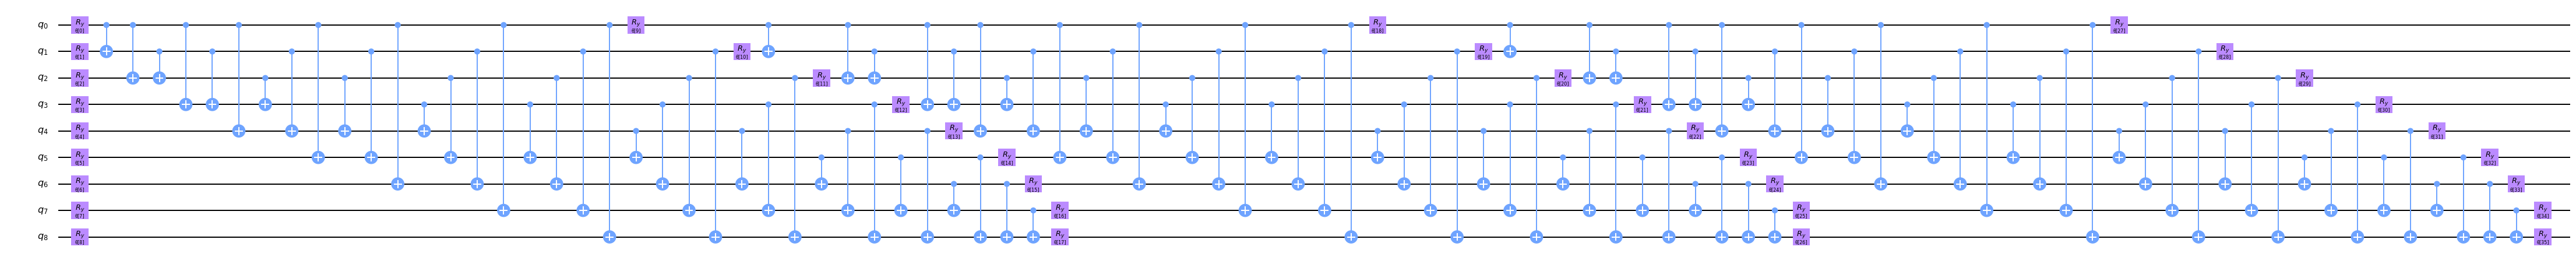

In [11]:
# Create the variational form.
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In [12]:
# Find the exact ground state eigenvalue of the qubit operator. Make sure that this result matches the previous
# ground state eigenvalue of the Hamiltonian above. This makes sure that everything went smoothly when
# converting the Hamiltonian to a qubit operator. 

# Note: This will not work for matrix operators.

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

AttributeError: 'MatrixOp' object has no attribute 'to_spmatrix'

In [13]:
# This is a callback function that will allow us to store information about the optimizer while the VQE is running.
# This is called when instantiating an object of the VQE class.

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

## Looping the VQE algorithm over several optimizers

The following cell runs the VQE algorithm multiple times in a for loop, each time with a different optimizer. You can use this to see which optimizer is the best for the Hamiltonian that you're running. For statevector simulators, in my experience, SLSQP is the best optimizer. But as you will see, for these quartic Hamiltonians, sometimes, the COBYLA actually converges the quickest, usually with a slightly more accurate result. If you are only interested in using a single optimizer (since looping the vqe will take substaintially longer run times), you can remove the for loop then replace the optimizer in the VQE class instantiation with any of the elements of the optimizer list (e.g., if you want to run SLSQP, instatiate the VQE class with optimizerList[0]). Note that for QASM simulators or running on real devices, the SPSA optimizer is the best. Also note that sometimes, the optimizers may not converge on the correct result, and you may have to run the vqe algorithm again to see what the result is on average.

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [14]:
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD

start_time = time.time()
warnings.filterwarnings("ignore")
backend = BasicAer.get_backend("statevector_simulator")

countArr = []
valArr = []
vqe_result = []
optimizerList = [SLSQP(maxiter=600), COBYLA(maxiter=5000), L_BFGS_B(maxfun=5000, maxiter=20000), NELDER_MEAD(maxfev=5000)]

for optimizer in optimizerList:

    counts = []
    values = []

    countArr.append(counts)
    valArr.append(values)

    vqe = VQE(qubitOp, var_form, optimizerList[0], callback=store_intermediate_result)
    ret = vqe.run(backend)
    vqe_result.append(np.real(ret['eigenvalue']))

print("VQE Result:", vqe_result)

end_time = time.time()
runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: [1.5295578e-07, 1.839044277e-05, 9.2491574e-07, 3.3298202e-07]
Program runtime: 61.60555362701416 s


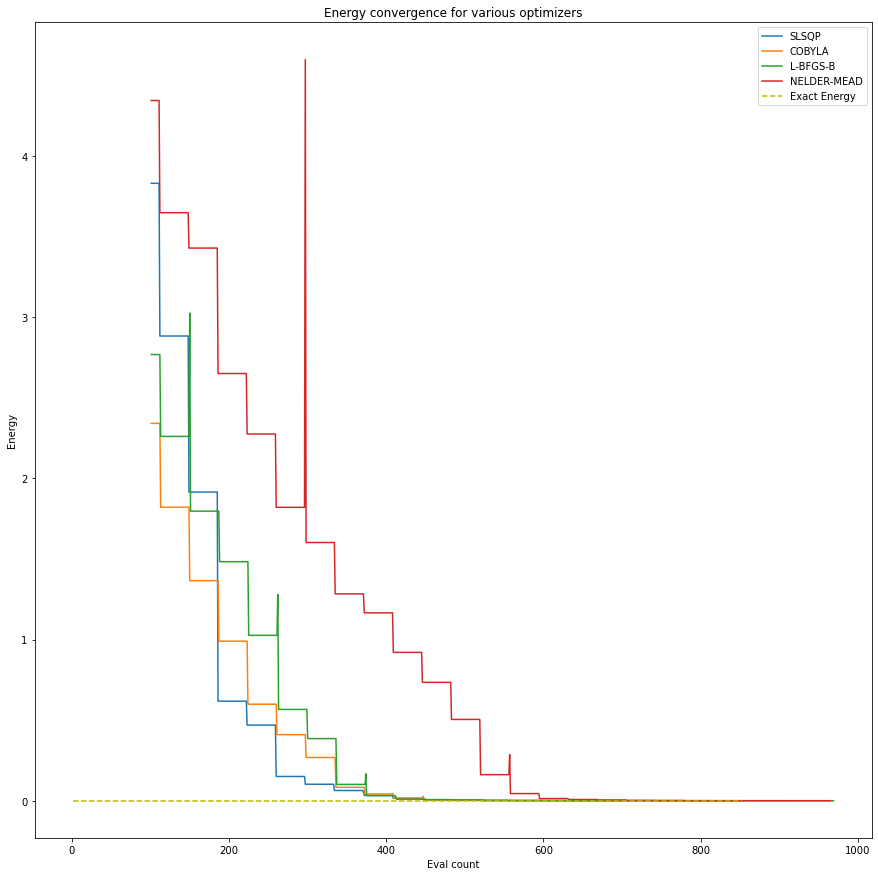

In [15]:
# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP", "COBYLA", "L-BFGS-B", "NELDER-MEAD"]

plt.figure(figsize=(15,15))

for i in range(0,len(optimizerList)):
    # Limit the range of the plot in order to make the convergence of each optimizer more visible.
    plt.plot(countArr[i][100:len(countArr[i])-1], valArr[i][100:len(valArr[i])-1], label=labelList[i])

plt.plot(countArr[0],[np.real(energies[0])]*len(countArr[0]), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [16]:
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backendQasm, shots=200)
optimizerQasm = SPSA(max_trials=1000)

counts = []
values = []

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizerQasm, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 0.04
Program runtime: 35.253618240356445 s


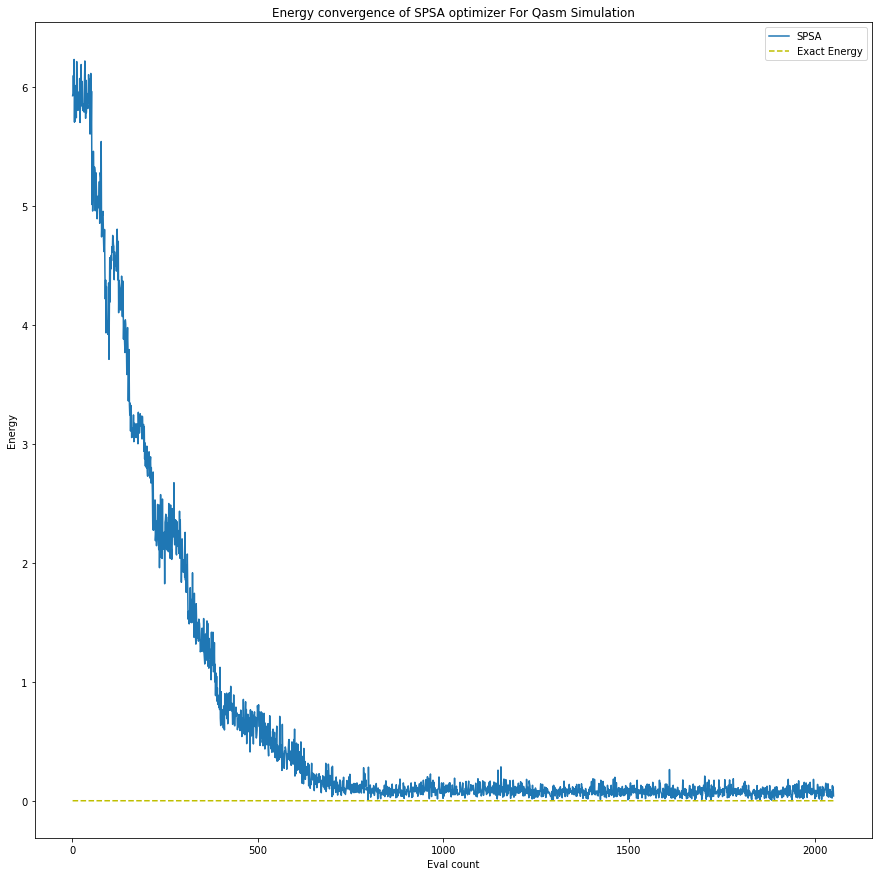

In [17]:
# Plot convergence plot for the SPSA optimizer
plt.figure(figsize=(15,15))
plt.plot(counts, values, label="SPSA")
plt.plot(counts,[np.real(energies[0])]*len(counts), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence of SPSA optimizer For Qasm Simulation')
plt.legend(loc='upper right')